# Offshore Oil and Gas Energy System Operation (OOGESO) - example case
Representing a hypothetical, but realistic offshore oil and gas platform with production rates

* crude oil: 50 Sm3/s, of which:
    * gas: 49.75 Sm3/s = 4.3 mill Sm3/day = 4300 Sm3oe/day
    * oil:  0.1 Sm3/s = 8640 Sm3/day  
    * water: 0.15 Sm3/s = 12960 Sm3/day 

(Comparison with e.g. Oseberg Sør 2019: 3560 Sm3oe/day (oil), 2440 Sm3oe/day (gas)

Gas oil ratio and water cut (standard units):
* GOR = 4.3 mill/8640 = 497
* WC = 12960/(12960+8640) = 0.6


### TODO
* CHECK pump_wellstream and pump_oil models

In [2]:
4.3e6/8640,12960/(12960+8640)

(497.68518518518516, 0.6)

In [146]:
#diameter:
#np.sqrt(4*50/100/(np.pi*15)),np.sqrt(4*0.1/(np.pi*2.5)),
#GOR:
#0.995/0.002
#WC:
0.003/(0.002+0.003)
#flowrate oil:
#np.sqrt(np.pi**2*0.2**5/(2*0.02*900*5000))*np.sqrt(0.5e6)

0.6

In [79]:
%load_ext autoreload
%autoreload 2
from oogeso import multicarrier
from oogeso import plots
import matplotlib.pyplot as plt
import IPython.display
import numpy as np
import pandas as pd
import logging
import pprint
import ipywidgets
import cloudpickle
#logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.INFO)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


_Configuration:_

In [80]:
case='1' # base case without wind
#case='1a' # case with 24 MW wind capacity
timerange=[0,1728] #one week
#timerange=[0,200]
outpath = "result_example2/"
pickle_save='{}case{}.pkl'.format(outpath,case)
plots.plotter="plotly"
#plots.plotter="matplotlib"

## Read input data

In [81]:
#plots.plotGasTurbineEfficiency(filename='gasturbine.png')

In [82]:
mc = multicarrier.Multicarrier(loglevel=logging.INFO,quadraticConstraints=False)
data,profiles = multicarrier.read_data_from_xlsx("data_example2.xlsx")
#data['paramDeviceEnergyInitially'][17]=2.5 # MWh - battery
for dev in ['Gen1','Gen2']:
    data['paramDeviceOnTimestepsInitially'][dev] = 10
    data['paramDeviceIsOnInitially'][dev] = 1
if case=='1':
    data['paramDevice']['wind']['Pmax']=0 # no wind

2020-09-19 19:07:39 INFO: TODO: objective function definition
2020-09-19 19:07:39 INFO: TODO: separator power (eta) and heat (eta2) demand
2020-09-19 19:07:39 INFO: TODO: gas turbine power vs heat output
2020-09-19 19:07:39 INFO: TODO: startup cost
2020-09-19 19:07:39 INFO: TODO: el source: dieselgen, fuel, on-off variables
2020-09-19 19:07:39 INFO: TODO: liquid pump approximation ok?
2020-09-19 19:07:39 INFO: TODO: startup delay does not work with Pmin>0
2020-09-19 19:07:39 INFO: TODO: flow vs pressure equations for liquid flows
2020-09-19 19:07:39 INFO: TODO: pressure deviation limits per node


In [83]:
instance = mc.createModelInstance(data,profiles)
#print("Writing instance to file.")
#instance.pprint(outpath+"problem_instance.txt")

In [84]:
xx=['','paramNode','paramEdge','paramDevice','paramCarriers','paramParameters','setProfile']
#xx=data.keys()
@ipywidgets.interact(datagroup=xx)
def showdata(datagroup):
    pprint.pprint(data[datagroup],width=1) if datagroup!='' else print('')

interactive(children=(Dropdown(description='datagroup', options=('', 'paramNode', 'paramEdge', 'paramDevice', …

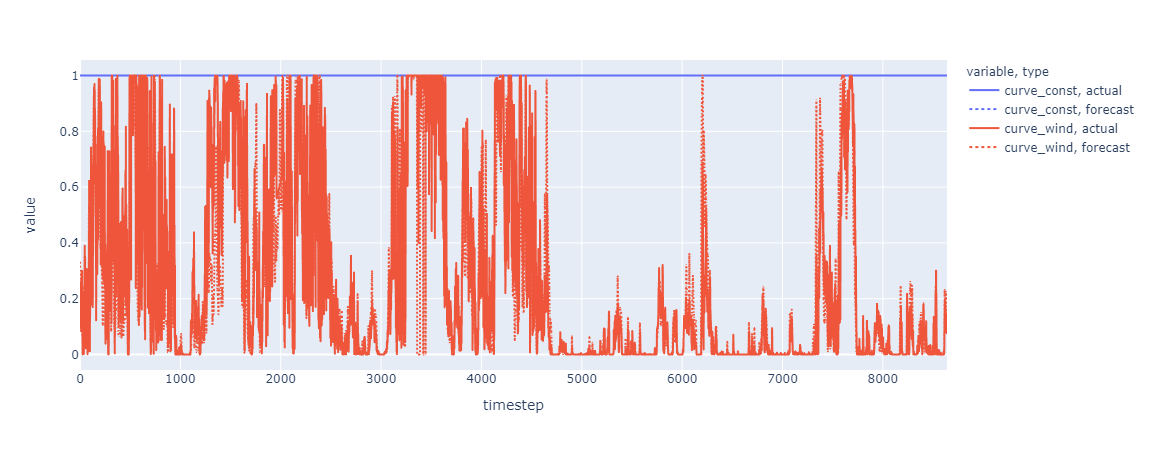

In [85]:
plots.plotProfiles(profiles,filename=None)

### Some checks on input data

In [86]:
print("flow per pipe = {:.4} Sm3/s".format(50/15))
flow1=multicarrier.Multicarrier.darcy_weissbach_Q(p1=6.164,p2=6,f=0.001,rho=5.63,
    diameter_mm=200,length_km=1,height_difference_m=100)
flow2=multicarrier.Multicarrier.darcy_weissbach_Q(p1=6.164,p2=4,f=0.0136,rho=5.63,
    diameter_mm=200,length_km=1,height_difference_m=100)
flow3=multicarrier.Multicarrier.darcy_weissbach_Q(p1=7,p2=4,f=0.0189,rho=5.63,
    diameter_mm=200,length_km=1,height_difference_m=100)
print("flow1 (6.164->6): {:.4}".format(flow1))
print("flow2 (6.164->4): {:.4}".format(flow2))
print("flow3 (7->4):     {:.4}".format(flow3))

flow per pipe = 3.333 Sm3/s
flow1 (6.164->6): 3.333
flow2 (6.164->4): 3.336
flow3 (7->4):     3.333


In [88]:
#transport-separator flow constraint seems ok
QQQ=50
print(6.00404116-(7- 1e-06*(1/15*QQQ-8.350301112430271)*2*997.1866725944546*119.41924718260051 - 1.0))
#wellstream pump:
#mc.compute_pump_demand(instance,'VSD_WST',Q=50,p1=6,p2=7,carrier="wellstream")
print("Pump power 6->6.146 MPa= {:.4} MW ({})".format(50*(6.164-6)/0.8,(6.164-6)/0.8))
print("Pump power 6->7 MPa    = {:4} MW ({})".format(50*(7-6)/0.8,(7-6)/0.8))

print(mc.instance.paramNode['transport'])

print("Pressure out={:.4} MPa".format(mc.compute_edge_pressuredrop(mc.instance,'c2',p1=6.164,Q=50/15,linear=False)))
print(mc.instance.paramEdge['c2'])

-1.1908328150549856
Pump power 6->6.146 MPa= 10.25 MW (0.20499999999999963)
Pump power 6->7 MPa    = 62.5 MW (1.25)
{'pressure.wellstream.out': 6.164, 'pressure.wellstream.in': 6.0}
Pressure out=4.003 MPa
{'include': 1.0, 'nodeFrom': 'transport', 'nodeTo': 'separator', 'type': 'wellstream', 'length_km': 1.0, 'diameter_mm': 200.0, 'height_m': 100.0, 'num_pipes': 15.0, 'pressure.from': 6.164, 'pressure.to': 4.0, 'temperature_K': 300.0}


In [89]:
# Water pipe pressure drop ('w3')
#mc.instance.paramEdge['w3']['num_pipes']=15
#mc.instance.paramEdge['w1']['diameter_mm']=200
print("Pressure out={:.4} MPa".format(mc.compute_edge_pressuredrop(mc.instance,'w1',p1=1.14,Q=1.15/3,linear=False)))
print(mc.instance.paramEdge['w1'])

Pressure out=0.6981 MPa
{'include': 1.0, 'nodeFrom': 'waterlift', 'nodeTo': 'pump_water', 'type': 'water', 'length_km': 0.01, 'diameter_mm': 200.0, 'height_m': 40.0, 'num_pipes': 3.0, 'pressure.from': 1.14, 'pressure.to': 0.7}


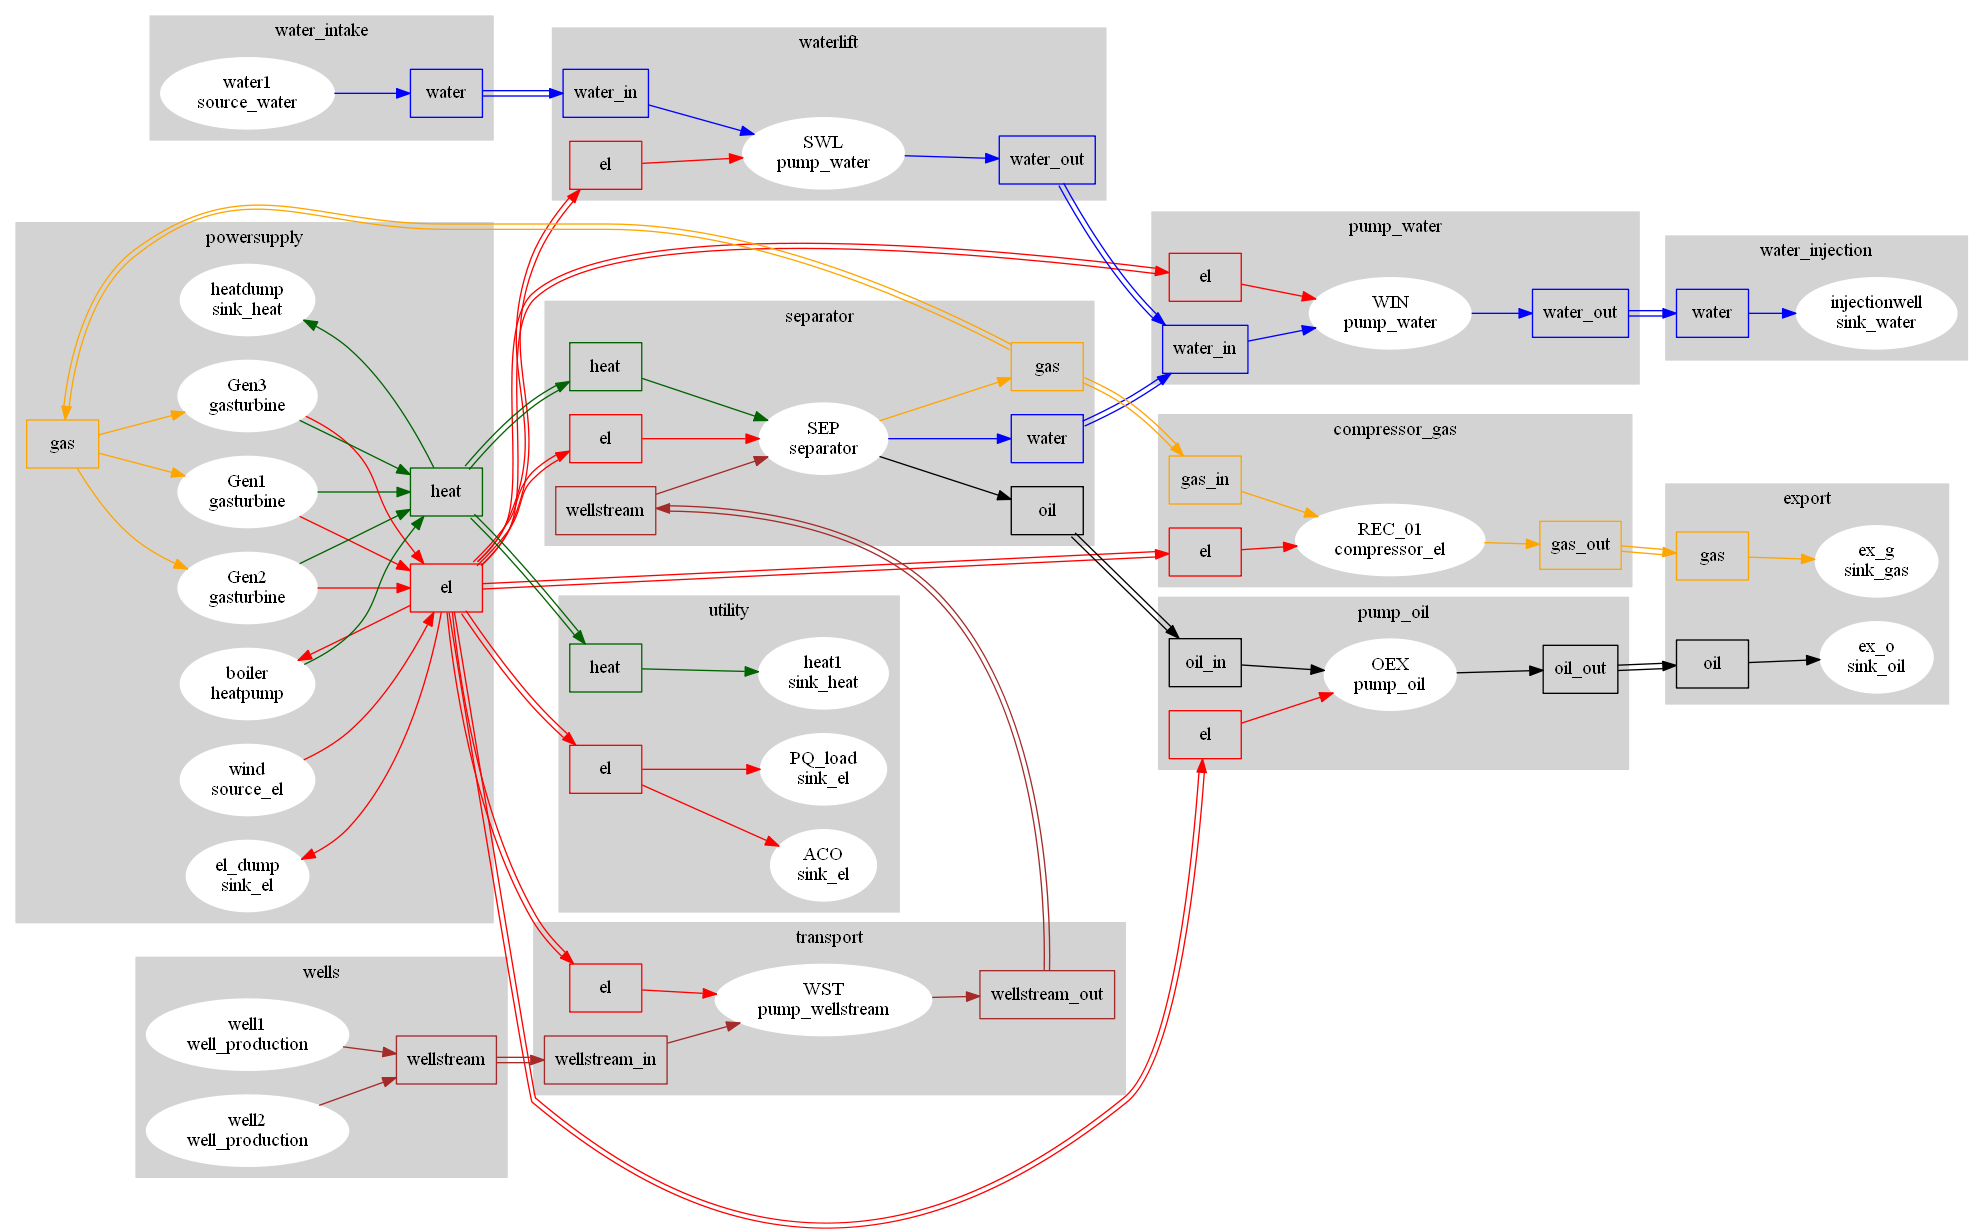

In [46]:
dotG=plots.plotNetwork(mc,timestep=None,filename=None)
#IPython.display.SVG(dotG.create_svg()) #original size, vector graphics
IPython.display.Image(dotG.create_png()) #scales automatically to page width

## Solve

If the problem is infeasible, try relaxing generic pressure deviation limits (input file "max_pressure_deviation")  
(Specify pressure deviation limit per node instead)
* Water injection Qmax restriction gives infeasible solution - WHY?? (adding el dump device doesn't help) Q changes from t=22 (low wind)
    * it seems to have to do with reserve capacity constraint

In [90]:
status = mc.solveMany(solver="cbc",timerange=timerange,write_yaml=False,timelimit=60)

sumCO2 = mc._dfCO2rate.mean()
co2intensity = mc._dfCO2intensity.mean()
exportrevenue = mc._dfExportRevenue.mean()
print("Mean CO2 emission rate      = {:.1f} kgCO2/s".format(sumCO2))
print("Mean CO2 emission intensity = {:.1f} kgCO2/Sm3oe".format(co2intensity))
print("Mean export revenue         =",*["{}:{:.1f} ".format(x,v) for x,v in mc._dfExportRevenue.mean().items() if v!=0],"$/s")

2020-09-19 19:08:01 INFO: Using solver timelimit=60
2020-09-19 19:08:01 INFO: Solving timestep=0
2020-09-19 19:08:04 INFO: Solving timestep=6
2020-09-19 19:08:06 INFO: Solving timestep=12
2020-09-19 19:08:08 INFO: Solving timestep=18
2020-09-19 19:08:11 INFO: Solving timestep=24
2020-09-19 19:08:13 INFO: Solving timestep=30
2020-09-19 19:08:15 INFO: Solving timestep=36
2020-09-19 19:08:17 INFO: Solving timestep=42
2020-09-19 19:08:20 INFO: Solving timestep=48
2020-09-19 19:08:22 INFO: Solving timestep=54
2020-09-19 19:08:23 INFO: Solving timestep=60
2020-09-19 19:08:26 INFO: Solving timestep=66
2020-09-19 19:08:28 INFO: Solving timestep=72
2020-09-19 19:08:30 INFO: Solving timestep=78
2020-09-19 19:08:32 INFO: Solving timestep=84
2020-09-19 19:08:34 INFO: Solving timestep=90
2020-09-19 19:08:36 INFO: Solving timestep=96
2020-09-19 19:08:38 INFO: Solving timestep=102
2020-09-19 19:08:40 INFO: Solving timestep=108
2020-09-19 19:08:42 INFO: Solving timestep=114
2020-09-19 19:08:44 INFO: S

Mean CO2 emission rate      = 9.0 kgCO2/s
Mean CO2 emission intensity = 61.4 kgCO2/Sm3oe
Mean export revenue         = oil:41.9  gas:19.2  $/s


In [25]:
#print(mc.instance.varDeviceFlow[('gasheater','gas','in',0)])
#mc.instance.constrDevice_ramprate.pprint()
#data['paramEdge']['c2']
#mc.instance.paramDevice['Gen1']
#instance.paramDevice.pprint()
#constr=mc.instance.constrEdgeFlowEquations['c2',0]
#print(constr.lower(),constr.upper())
#constr.pprint()
#mc.instance.constrEdgeFlowEquations.pprint("constrEdgeFlow.txt")
#mc.instance.paramNode.pprint()
#print("pressure deviation:",(9.93-10)/10,(5.27-5)/5,(6.16-6.164)/6.164, (6.53-7)/7)

## Compute KPIs

In [91]:
hour_per_year=8760
sec_per_year=3600*hour_per_year
kpi = {}

num_sim_timesteps=mc._dfCO2rate.shape[0]
timesteps=mc._dfCO2rate.index
kpi['hours_simulated'] = num_sim_timesteps*mc.instance.paramParameters['time_delta_minutes']/60

# CO2 emissions
kpi['kgCO2_per_year'] = mc._dfCO2rate.mean()*sec_per_year
kpi['kgCO2_per_Sm3oe'] = mc._dfCO2intensity.mean()

# hours with reduced load
kpi['reducedload_hours_per_year'] = None

# hours with load shedding
kpi['loadshed_hours_per_year'] = None

# fuel consumption
gasturbines = [i for i,g in mc.instance.paramDevice.items() if g['model']=='gasturbine']
mask_gt=mc._dfDeviceFlow.index.get_level_values('device').isin(gasturbines)
gtflow = mc._dfDeviceFlow[mask_gt]
fuel = gtflow.unstack('carrier')['gas'].unstack('terminal')['in'].unstack().mean(axis=1)
kpi['gt_fuel_sm3_per_year'] = fuel.sum()*sec_per_year

# electric power consumption
el_dem=mc._dfDeviceFlow.unstack('carrier')['el'].unstack('terminal')['in'].dropna().unstack().mean(axis=1)
kpi['elconsumption_mwh_per_year'] = el_dem.sum()*hour_per_year


# number of generator starts
gt_starts = mc._dfDeviceStarting.unstack().sum(axis=1)[gasturbines].sum()
kpi['gt_starts_per_year'] = gt_starts*hour_per_year/kpi['hours_simulated']

# number of generator stops
gt_stops = mc._dfDeviceStopping.unstack().sum(axis=1)[gasturbines].sum()
kpi['gt_stops_per_year'] = gt_stops*hour_per_year/kpi['hours_simulated']

# running hours of generators
gt_ison = mc._dfDeviceIsOn.unstack().sum(axis=1)[gasturbines].sum()
kpi['gt_hoursrunning_per_year'] = gt_ison*hour_per_year/kpi['hours_simulated']

# wind power output 
windturbines = ['wind']
el_sup=mc._dfDeviceFlow.unstack('carrier')['el'].unstack('terminal')['out'].dropna().unstack()
p_wind = el_sup.T[windturbines]
kpi['wind_output_mwh_per_year'] = p_wind.sum(axis=1).mean()*hour_per_year

# curtailed wind energy
p_avail = pd.DataFrame(index=timesteps)
for d in windturbines:
    devparam=mc.instance.paramDevice[d]
    Pmax = devparam['Pmax']
    p_avail[d] = Pmax
    if 'profile' in devparam:
        profile_ref = devparam['profile']
        p_avail[d] = Pmax * mc._df_profiles_actual.loc[timesteps,profile_ref]
p_curtailed = (p_avail - p_wind).sum(axis=1)
kpi['wind_curtailed_mwh_per_year'] = p_curtailed.mean()*hour_per_year

mc.kpi = kpi
kpi

{'hours_simulated': 144.0,
 'kgCO2_per_year': 282467082.8678494,
 'kgCO2_per_Sm3oe': 61.38182094991603,
 'reducedload_hours_per_year': None,
 'loadshed_hours_per_year': None,
 'gt_fuel_sm3_per_year': 120712428.57600018,
 'elconsumption_mwh_per_year': 404565.2816508014,
 'gt_starts_per_year': 60.833333333333336,
 'gt_stops_per_year': 0.0,
 'gt_hoursrunning_per_year': 315360.0,
 'wind_output_mwh_per_year': 0.0,
 'wind_curtailed_mwh_per_year': 0.0}

In [111]:
(mc._dfDeviceStarting!=0)

device  time
ACO     0       False
        1       False
        2       False
        3       False
        4       False
                ...  
wind    1723    False
        1724    False
        1725    False
        1726    False
        1727    False
Name: 0, Length: 38016, dtype: bool

## Save/Load simulation results

In [92]:
# Save (pickle) - for later opening and analysis
with open(pickle_save, mode='wb') as file:
   cloudpickle.dump(mc, file)

In [5]:
# Open previously saved object (including simulation results)
with open(pickle_save, mode='rb') as file:
   mc_loaded = cloudpickle.load(file)

In [51]:
with open(outpath+'case1.pkl', mode='rb') as file:
   mc_1 = cloudpickle.load(file)
with open(outpath+'case1a.pkl', mode='rb') as file:
   mc_1a = cloudpickle.load(file)

## Analyse results

In [93]:
print(case)

1


In [ ]:
1946/144

In [98]:
mc_1a.kpi

{'hours_simulated': 144.0,
 'kgCO2_per_year': 216188159.6073533,
 'kgCO2_per_Sm3oe': 46.72794043221912,
 'reducedload_hours_per_year': None,
 'loadshed_hours_per_year': None,
 'gt_fuel_sm3_per_year': 92388102.39630541,
 'elconsumption_mwh_per_year': 407736.0591587756,
 'gt_starts_per_year': 1946.6666666666667,
 'gt_stops_per_year': 1946.6666666666667,
 'gt_hoursrunning_per_year': 228550.83333333334,
 'wind_output_mwh_per_year': 91298.07752295483,
 'wind_curtailed_mwh_per_year': 363.9248005619162}

In [143]:
df_kpi=pd.DataFrame()
df_kpi=pd.concat([
    pd.DataFrame.from_dict(mc.kpi,orient="index",columns=['1']),
    pd.DataFrame.from_dict(mc_1a.kpi,orient="index",columns=['1a'])
],axis=1)
print("Difference from base case\n---------------------------------abs------------rel------")
for i,r in df_kpi.iterrows():
    print("{:30}: {:12.6g}    {:10.6g}".format(i,r['1a']-r['1'],r['1a']/r['1']))
#(df_kpi['1a']-df_kpi['1'])

Difference from base case
---------------------------------abs------------rel------
hours_simulated               :            0             1
kgCO2_per_year                : -6.62789e+07      0.765357
kgCO2_per_Sm3oe               :     -14.6539      0.761267
reducedload_hours_per_year    :          nan           nan
loadshed_hours_per_year       :          nan           nan
gt_fuel_sm3_per_year          : -2.83243e+07      0.765357
elconsumption_mwh_per_year    :      3170.78       1.00784
gt_starts_per_year            :      1885.83            32
gt_stops_per_year             :      1946.67           inf
gt_hoursrunning_per_year      :     -86809.2       0.72473
wind_output_mwh_per_year      :      91298.1           inf
wind_curtailed_mwh_per_year   :      363.925           inf


C:\Users\hsven\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning:

divide by zero encountered in double_scalars



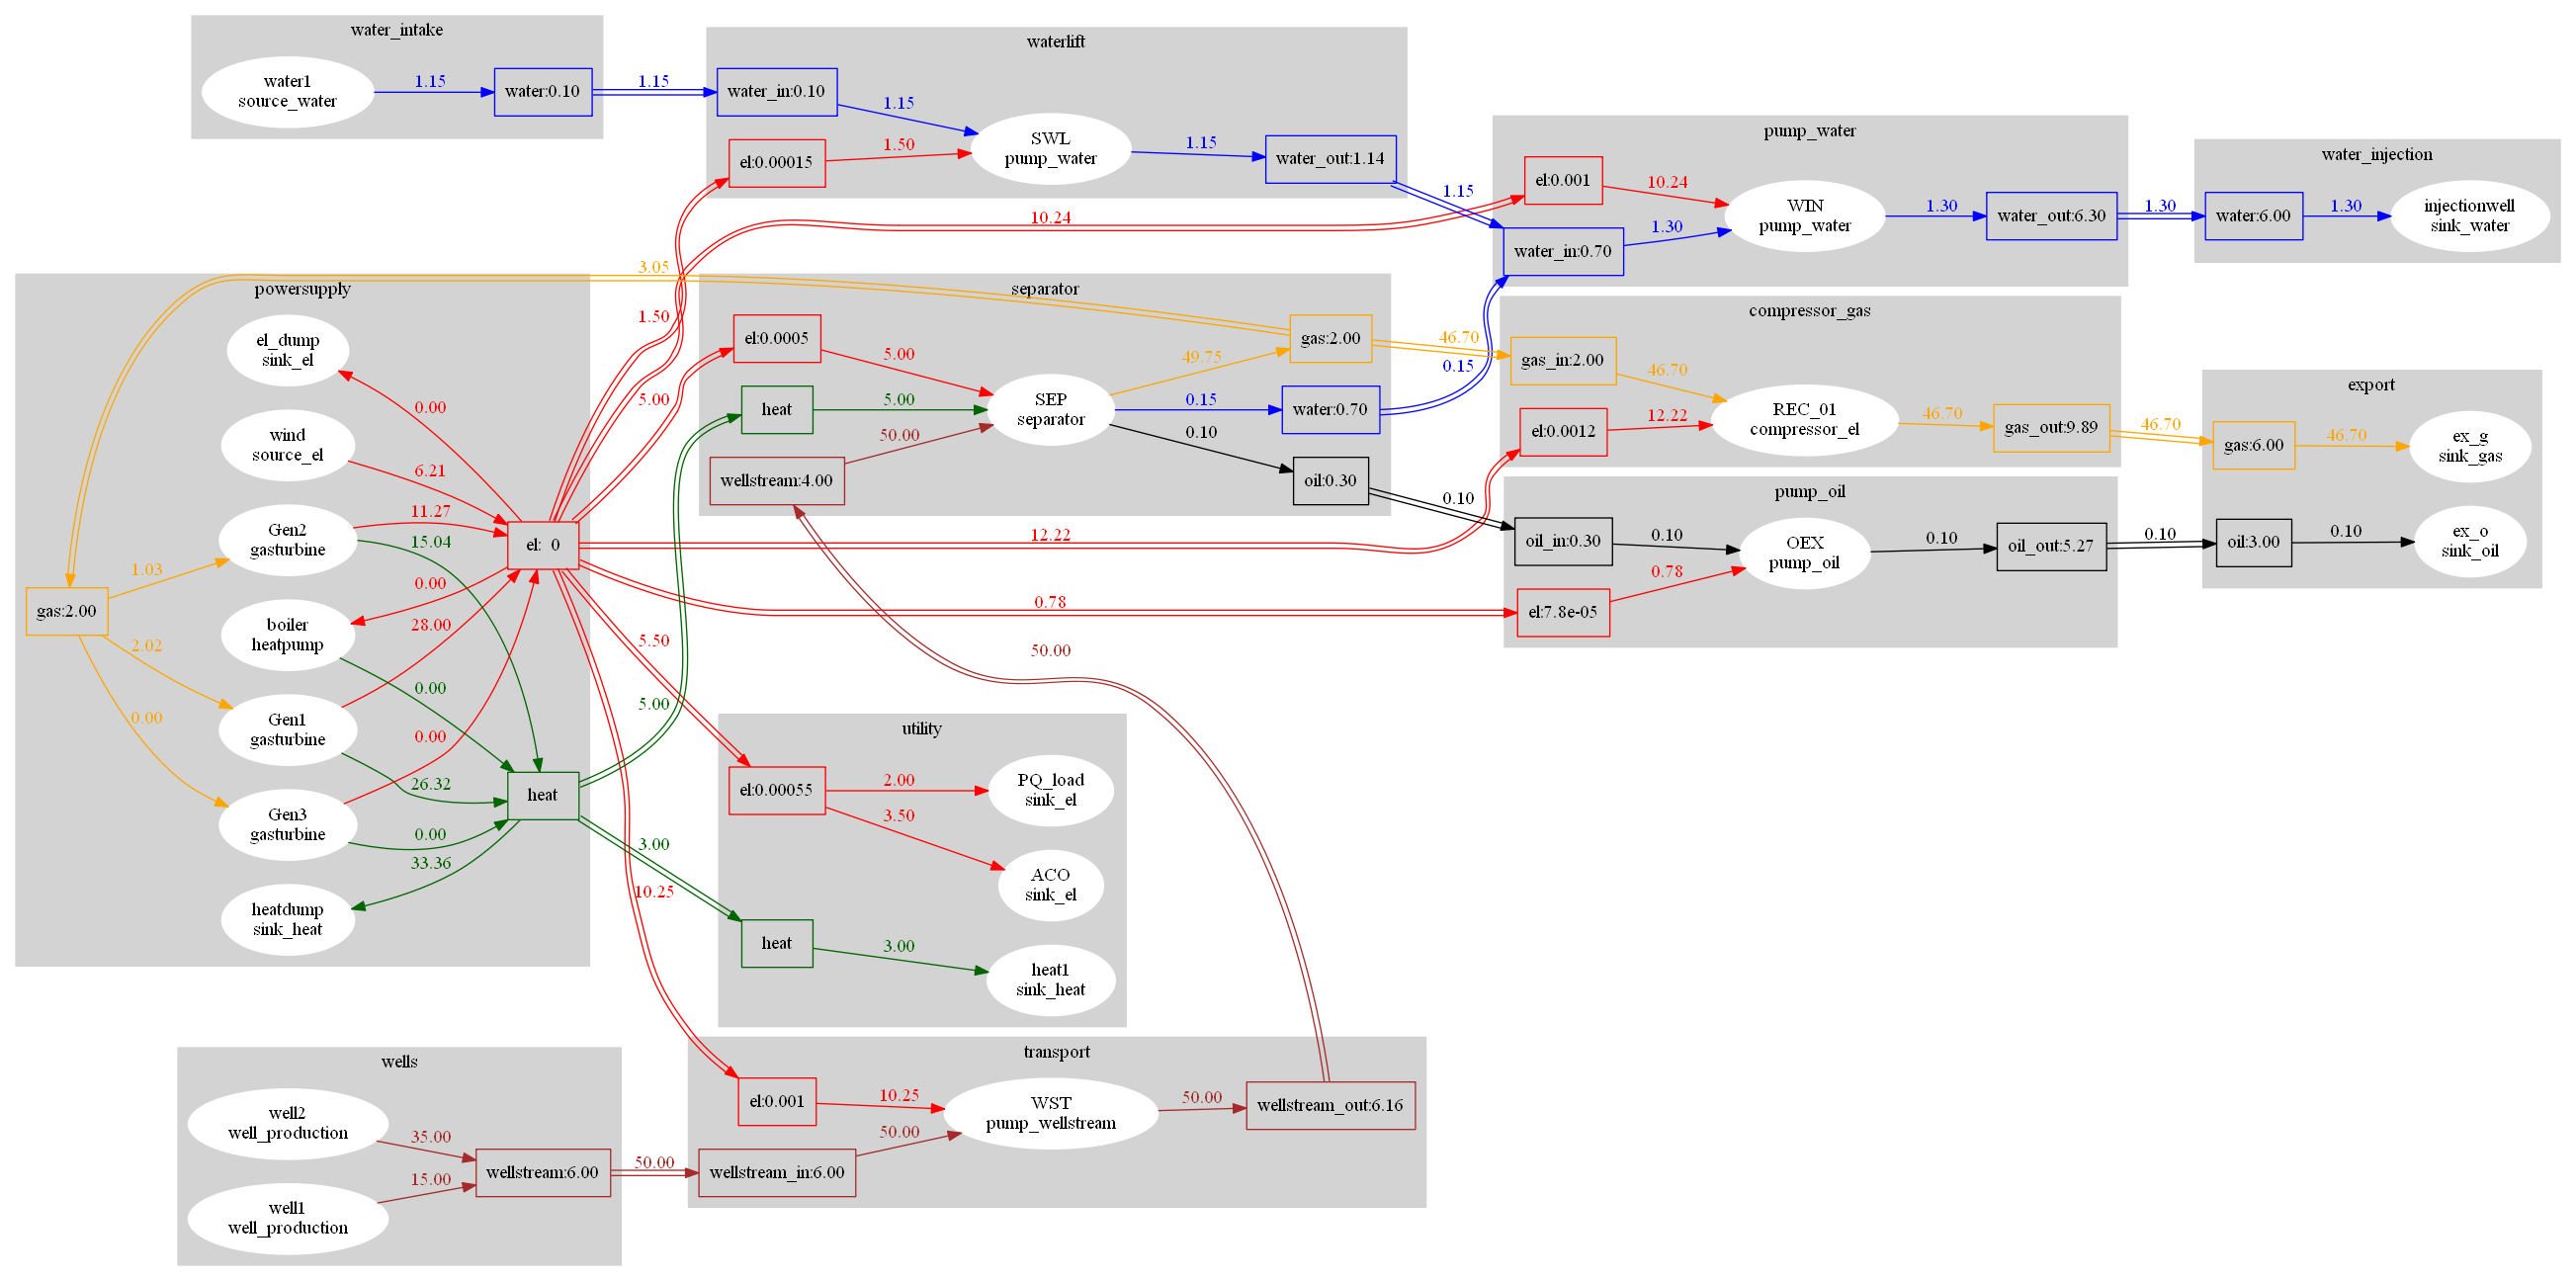

In [540]:
tstep=6
gCombined = plots.plotNetwork(mc,timestep=tstep,
    filename=outpath+"network_combined.png")
for carr in []:
#for carr in ['el','heat','gas','oil','wellstream','water']:
    plots.plotNetwork(mc,timestep=tstep,only_carrier=[carr],
        filename=outpath+"network_{}_{}.png".format(carr,tstep))
#gCombined=plots.plotNetwork(mc,timestep=tstep,only_carrier='el',rankdir='TB')
#gHeat = plots.plotNetwork(mc,timestep=tstep,only_carrier='heat')
#gGas = plots.plotNetwork(mc,timestep=tstep,only_carrier='gas')
#gOil = plots.plotNetwork(mc,timestep=tstep,only_carrier='oil')
#gWater = plots.plotNetwork(mc,timestep=tstep,only_carrier='water')
IPython.display.Image(gCombined.create_png())

Notes to figure:
* Electrical power going into separator - Is this already included in the gas re-compression?
* Oil export pump power demand turns out very small (0.3 MW) for flow 0.1 Sm3/s and pressure increase from 0.3 to 3 MPa - is this realistic?
* Why is water injection higher than minimum value? (limiting gives infeasible solution - eiteher Q must be allowed higher, or pressure must be allowed to deviate - but why?)

In [484]:
#mc.instance.paramCarriers.pprint()
#mc.instance.paramEdge['w3']
#mc.instance.paramEdge['w3']['diameter_mm']=200

In [485]:
print("CHECKING edge pressure drop")
#mc.computeEdgePressureDrop(tstep)
print('c2:',mc.compute_edge_pressuredrop(mc.instance,edge='c2',Q=50/15,p1=10,linear=False))
print('w1:',mc.compute_edge_pressuredrop(mc.instance,edge='w1',Q=1.15,p1=0.7,linear=True))
print('w3:',mc.compute_edge_pressuredrop(mc.instance,edge='w3',Q=1.3/15,p1=7,linear=False))
print('o2:',mc.compute_edge_pressuredrop(mc.instance,edge='o2',Q=0.1,p1=5,linear=True))
print('g2:',mc.compute_edge_pressuredrop(mc.instance,edge='g2',Q=48,p1=10,linear=True))
mc.checkEdgePressureDrop(timestep=1,var="outer")

CHECKING edge pressure drop
c2: 7.839392263020411
w1: 0.10778194195115598
w3: 6.117756712984327
o2: 2.7294247394969373
g2: 5.889546177373956
wellstream edge c1:wells-transport (Q=50.0 m3/s)
	NOMINAL:    pin=6.0  pout=6.0  pout_computed=-42.487 pout_linear=  6
	SIMULATION: pin=6.0  pout=6.0  pout_computed=-42.487 pout_linear=  6
	flow velocity = 1591.5 m/s
wellstream edge c2:transport-separator (Q=50.0 m3/s)
	NOMINAL:    pin=6.164  pout=4.0  pout_computed=4.0034 pout_linear=4.0034
	SIMULATION: pin=6.1606064  pout=4.0  pout_computed=  4 pout_linear=  4
	flow velocity = 106.1 m/s
oil edge o1:separator-pump_oil (Q=0.1 m3/s)
	NOMINAL:    pin=0.3  pout=0.3  pout_computed=0.29595 pout_linear=0.3
	SIMULATION: pin=0.3  pout=0.3  pout_computed=0.29595 pout_linear=0.3
	flow velocity = 3.1831 m/s
oil edge o2:pump_oil-export (Q=0.1 m3/s)
	NOMINAL:    pin=5.0  pout=3.0  pout_computed=2.9755 pout_linear=2.7294
	SIMULATION: pin=5.2705753  pout=3.0  pout_computed=3.2461 pout_linear=  3
	flow velocity =

Notes to the above computed edge flows:  
* velocity of wellstream transport is very high.But it is not an incompressible liquid, so the density is not fixed (should be higher as the pressure is high)
    * compressibility $\rho = \rho_b\exp[c(p-p_b)]$; $p_b,\rho_b$ is pressure and density at XX. $c$ is the compressibility
    * " Density of reservoir oil varies from 30 lbm/ft3 for light volatile oils to 60 lbm/ft3 for heavy crudes with little or no solution gas. (480-961 kg/m3) 
    * "Oil compressibility may range from 3e6 psi^-1 for heavy crude oils to 50e6 psi^-1 for light oils. " (1 psi = 6894.76 Pa) => c = 438/Pa - 7251/Pa
    * p_b=0.1 MPa, rho_b=5.6 kg/m3 (cf above), c=6000/Pa, p=6 MPa => rho=OVERFLOW ERROR
* pressure drop for oil pipelines is very large 14 MPa/5km / 0.03 MPa/0.1km - and flow velocity (13 m/s) is probably too high **--improved by using 200mm instead of 100mm pipes: 3.1 m/s and 0.5 MPa/5km, 0.001MPa/0.1km**
* Clearly ERROR in wellstream and water pipe pressure drop computations => multiple parallel pipes fixes

In [459]:
50/6894.76,5.6*np.exp(6e-6*(6-0.1)*1e6)

(0.007251884039473455, 1.3249902618133818e+16)

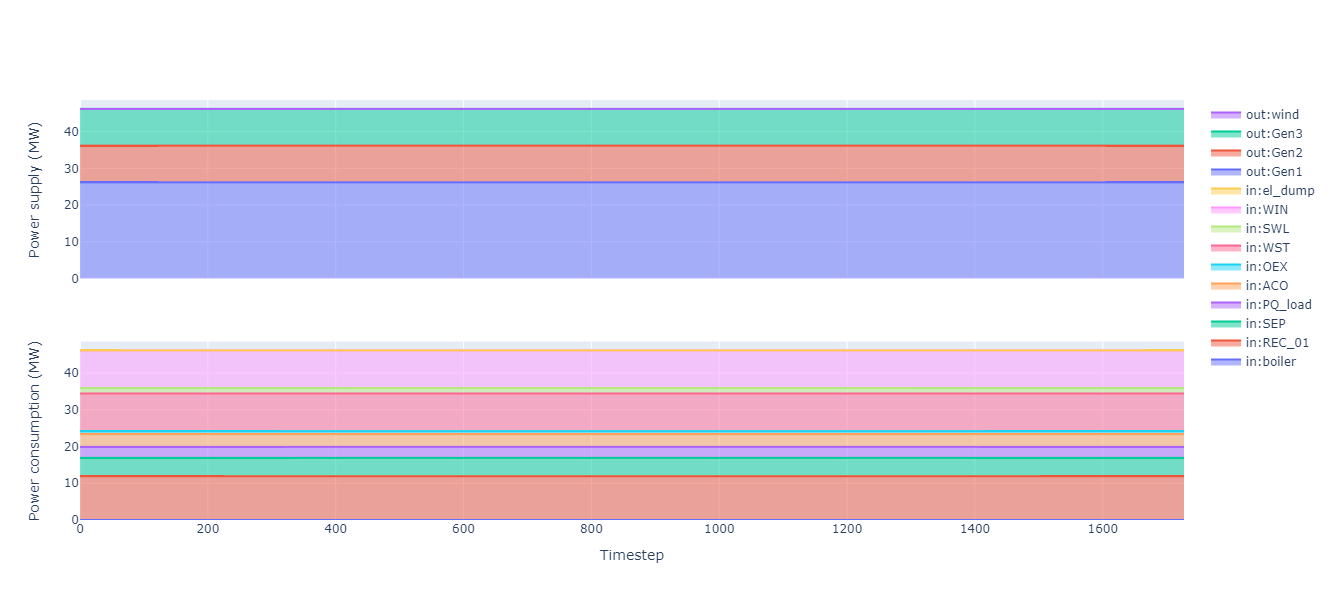

In [106]:
#plots.plot_SumPowerMix(mc,carrier="el",filename=outpath+"el_sum_opt.png")
plots.plotter='plotly'
fig=plots.plot_SumPowerMix(mc,carrier="el",filename=None)
#plots.plotter='matplotlib'
#fig2=plots.plot_SumPowerMix(mc,carrier="el",filename=None)

<AxesSubplot:ylabel='device'>

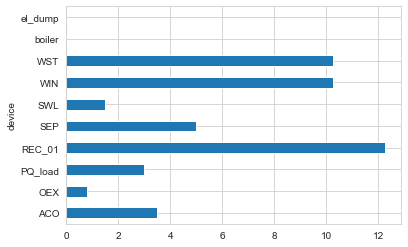

In [31]:
mean_el_demand = mc._dfDeviceFlow.unstack('carrier')['el'].unstack('terminal')['in'].dropna().unstack().T.mean()
mean_heat_demand = mc._dfDeviceFlow.unstack('carrier')['heat'].unstack('terminal')['in'].dropna().unstack().T.mean()
mean_el_demand.plot.barh()

<AxesSubplot:ylabel='device'>

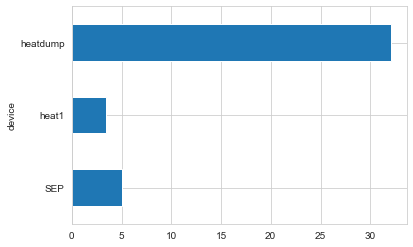

In [33]:
mean_heat_demand.plot.barh()

In [32]:
mean_el_demand

device
ACO         3.500000
OEX         0.783309
PQ_load     3.000000
REC_01     12.260551
SEP         4.999844
SWL         1.497675
WIN        10.253667
WST        10.249681
boiler      0.000000
el_dump     0.000485
dtype: float64

In [34]:
mean_el_demand.sum()

46.545212232736944

<AxesSubplot:xlabel='time'>

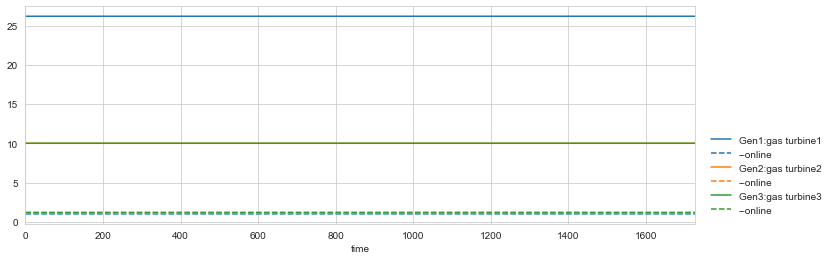

In [107]:
gts = [d for d in mc.instance.setDevice 
       if mc.instance.paramDevice[d]['model']=='gasturbine']
#plots.plot_deviceprofile(mc,devs=gts,profiles=profiles,filename=outpath+"GTs_opt.png")
plots.plot_deviceprofile(mc,devs=gts,profiles=profiles,filename=None)

In [492]:
#df.dropna(how='all')
#mc._dfDeviceFlow.unstack([0,1,2]).columns
#mc._dfDeviceFlow.unstack([0,1,2])[[('ex_g','gas','in'),('ex_o','oil','in')]]
#mc._dfDeviceFlow.unstack([1,2])[('el','out')].unstack(0)

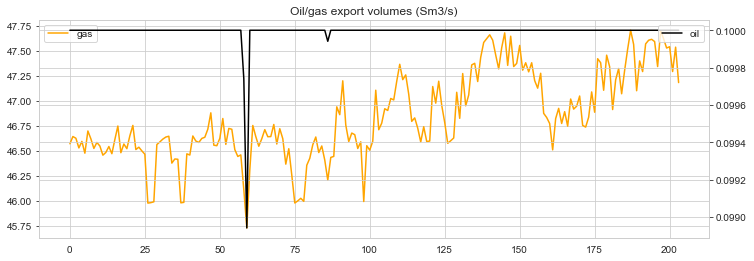

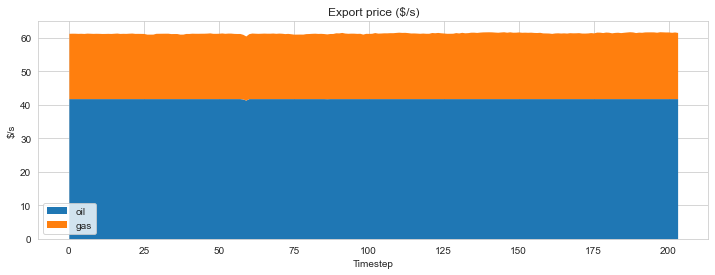

In [493]:
plt.figure(figsize=(12,4))
ax=plt.gca()
labels=[]
#df=mc._dfDevicePower.unstack(0)[['ex_g','ex_o']]
df=mc._dfDeviceFlow.unstack([0,1,2])[[('ex_g','gas','in'),('ex_o','oil','in')]]
ax.plot(df['ex_g'],label='gas',color='orange')
ax.legend(loc='upper left')
ax2=ax.twinx()
ax2.plot(df['ex_o'],label='oil',color='black')
ax2.legend(loc='upper right')
plt.title("Oil/gas export volumes (Sm3/s)")

#    ax.legend(labels,loc='lower left', bbox_to_anchor =(1.01,0),
#              frameon=False)
#plt.savefig(outpath+"export.png",bbox_inches = 'tight')

plots.plot_ExportRevenue(mc)

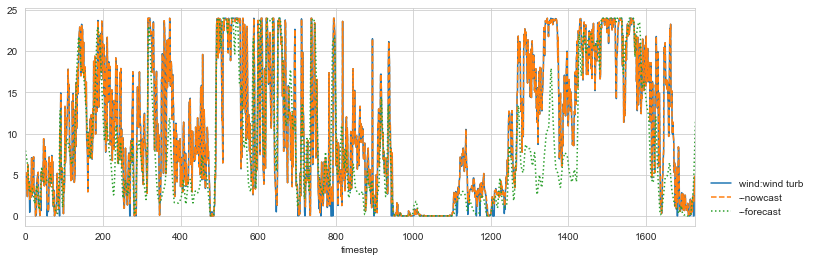

In [36]:
if 'wind' in mc.instance.setDevice:
    plots.plot_deviceprofile(mc,devs=['wind'],profiles=profiles,
                             filename=None)#outpath+"WT_opt.png")

In [495]:
if 'battery' in mc.instance.setDevice:
    plots.plot_devicePowerEnergy(mc,'battery',
                                 filename=None)#outpath+"battery_opt.png")
    multicarrier.Plots.plotDevicePowerLastOptimisation1(mc,device='battery',
                filename=None)#outpath+"lastopt_battery.png")

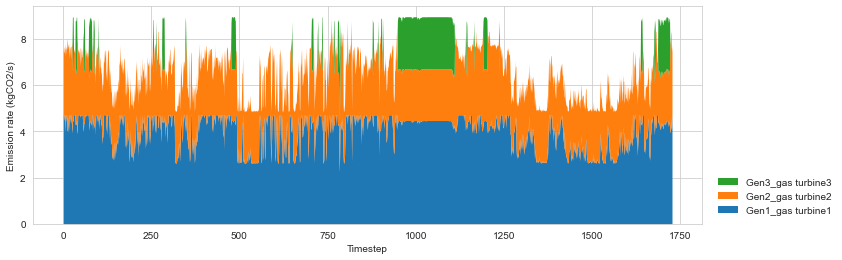

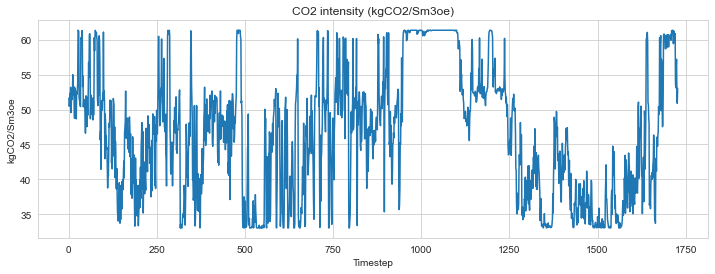

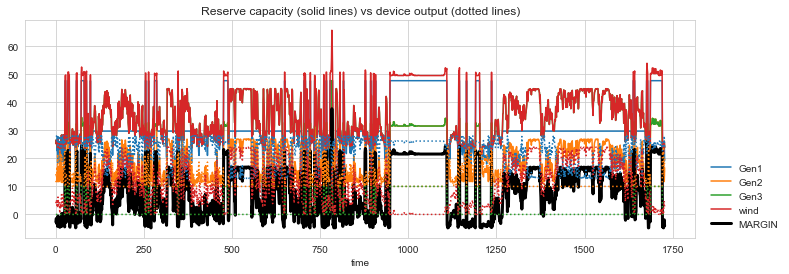

In [37]:
plots.plot_CO2rate_per_dev(mc,reverseLegend=True)#,filename=outpath+"co2rate_opt.png")
plots.plot_CO2_intensity(mc)#,filename=outpath+"co2intensity_opt.png")
plots.plotElReserve(mc)#,filename=outpath+"elReserve.png")


#p=plots.plot_df(mc._dfDevicePower,id_var="device",filename=None,#outpath+"plotly.html",
#              title="Device Power",ylabel="Power (MW)")
#df_long=mc._dfDeviceFlow#.reset_index().rename(columns={0:'value'})
#p=plots.plot_df(df_long,id_var="device",filename=None,#outpath+"plotly.html",
#              title="Device energy/fluid flow",ylabel="(MW or Sm3/s)")


# Last optimisisation (results for a horizon)
#multicarrier.Plots.plotDeviceSumPowerLastOptimisation(instance,
#                                                      filename=outpath+"lastopt_devsum_el.png")
#multicarrier.Plots.plotEmissionRateLastOptimisation(instance,filename=outpath+"lastopt_co2out.png")


